# Zero-coupon vs. Market yields

A zero-coupon yeild is a "synthetic" construct. It is next to impossible to find an actual zero-coupon bond with the exact tenor that trades at those yeilds. It is primarily used as an input to quant/risk models because it is "pure." 

Market yields are shaped mostly by supply and demand. So it is a useful measure for a practical risk-free rate. 

pluto has [zero-coupon](https://plutopy.readthedocs.io/en/latest/YieldCurve.html#plutoPy.model.YieldCurve.IndiaZeroCoupon) rates starting from 2011-01-18 and a market [based bond index](https://plutopy.readthedocs.io/en/latest/Indices.html#plutoPy.model.Indices.IndiaGsecTimeSeries) starting from 2003-12-31. We will plot the yields of the two below to get a sense of the difference between the two.

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
indices <- Indices() #for IndiaGsecTimeSeries
ycurves <- YieldCurve() #for IndiaZeroCoupon

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘PerformanceAnalytics’

The following obje

In [2]:
startEndDatesIndex <- (indices$IndiaGsecTimeSeries() %>%
    summarize(MAX_TS = max(TIME_STAMP), MIN_TS = min(TIME_STAMP)) %>%
    collect())

startEndDatesZero <- (ycurves$IndiaZeroCoupon() %>%
    summarize(MAX_TS = max(TIME_STAMP), MIN_TS = min(TIME_STAMP)) %>%
    collect())

startDate <- max(startEndDatesIndex$MIN_TS[[1]], startEndDatesZero$MIN_TS[[1]])
endDate <- min(startEndDatesIndex$MAX_TS[[1]], startEndDatesZero$MAX_TS[[1]])

indexDt <- (indices$IndiaGsecTimeSeries() %>%
            filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
            select(TIME_STAMP, NAME, YIELD = YTM) %>%
            collect() %>%
            mutate(MATURITY = as.numeric(strsplit(NAME, "_")[[1]][2])) %>% 
            select(TIME_STAMP, MATURITY, YIELD))

ycDt <- (ycurves$IndiaZeroCoupon() %>%
            filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate 
                   & MATURITY %in% c(5, 10, 15, 20, 30)) %>%
            collect())

print("bond index data:")
print(head(indexDt))
print(tail(indexDt))

print("zero-coupon data:")
print(head(ycDt))
print(tail(ycDt))


Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

[1] "bond index data:"
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <dbl> <dbl>
1 2011-01-18        5  7.94
2 2011-01-19        5  7.96
3 2011-01-20        5  7.93
4 2011-01-21        5  7.93
5 2011-01-22        5  7.93
6 2011-01-23        5  7.93
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <dbl> <dbl>
1 2019-07-11        5  6.67
2 2019-07-12        5  6.65
3 2019-07-13        5  6.65
4 2019-07-14        5  6.65
5 2019-07-15        5  6.62
6 2019-07-16        5  6.56
[1] "zero-coupon data:"
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <dbl> <dbl>
1 2011-01-18        5  7.75
2 2011-01-18       10  8.23
3 2011-01-18       15  8.42
4 2011-01-18       20  8.51
5 2011-01-18       30  8.60
6 2011-01-19        5  7.74
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <dbl> <dbl>
1 2019-07-15       30  6.92
2 2019-07-16        5  6.28
3 2019-07-16       10  6.55
4 2019-07-16       15  6.70
5 2019-07-16       20  6.79
6 2019-07-16 

In [3]:
sprdDf <- indexDt %>% 
    inner_join(ycDt, by=c('TIME_STAMP', 'MATURITY')) %>%
    mutate(SPREAD = 100*(YIELD.x - YIELD.y)) %>%
    as.data.frame()

print(head(sprdDf))
print(tail(sprdDf))

  TIME_STAMP MATURITY YIELD.x  YIELD.y    SPREAD
1 2011-01-18        5  7.9377 7.747290 19.040969
2 2011-01-19        5  7.9570 7.741942 21.505752
3 2011-01-20        5  7.9317 7.736582 19.511765
4 2011-01-21        5  7.9292 7.850067  7.913345
5 2011-01-24        5  7.9290 7.858808  7.019185
6 2011-01-25        5  7.9126 7.865070  4.753006
      TIME_STAMP MATURITY YIELD.x  YIELD.y   SPREAD
10160 2019-07-09        5  6.7452 6.426586 31.86138
10161 2019-07-10        5  6.7081 6.409818 29.82816
10162 2019-07-11        5  6.6746 6.360393 31.42067
10163 2019-07-12        5  6.6476 6.340548 30.70522
10164 2019-07-15        5  6.6163 6.310003 30.62967
10165 2019-07-16        5  6.5579 6.275604 28.22956


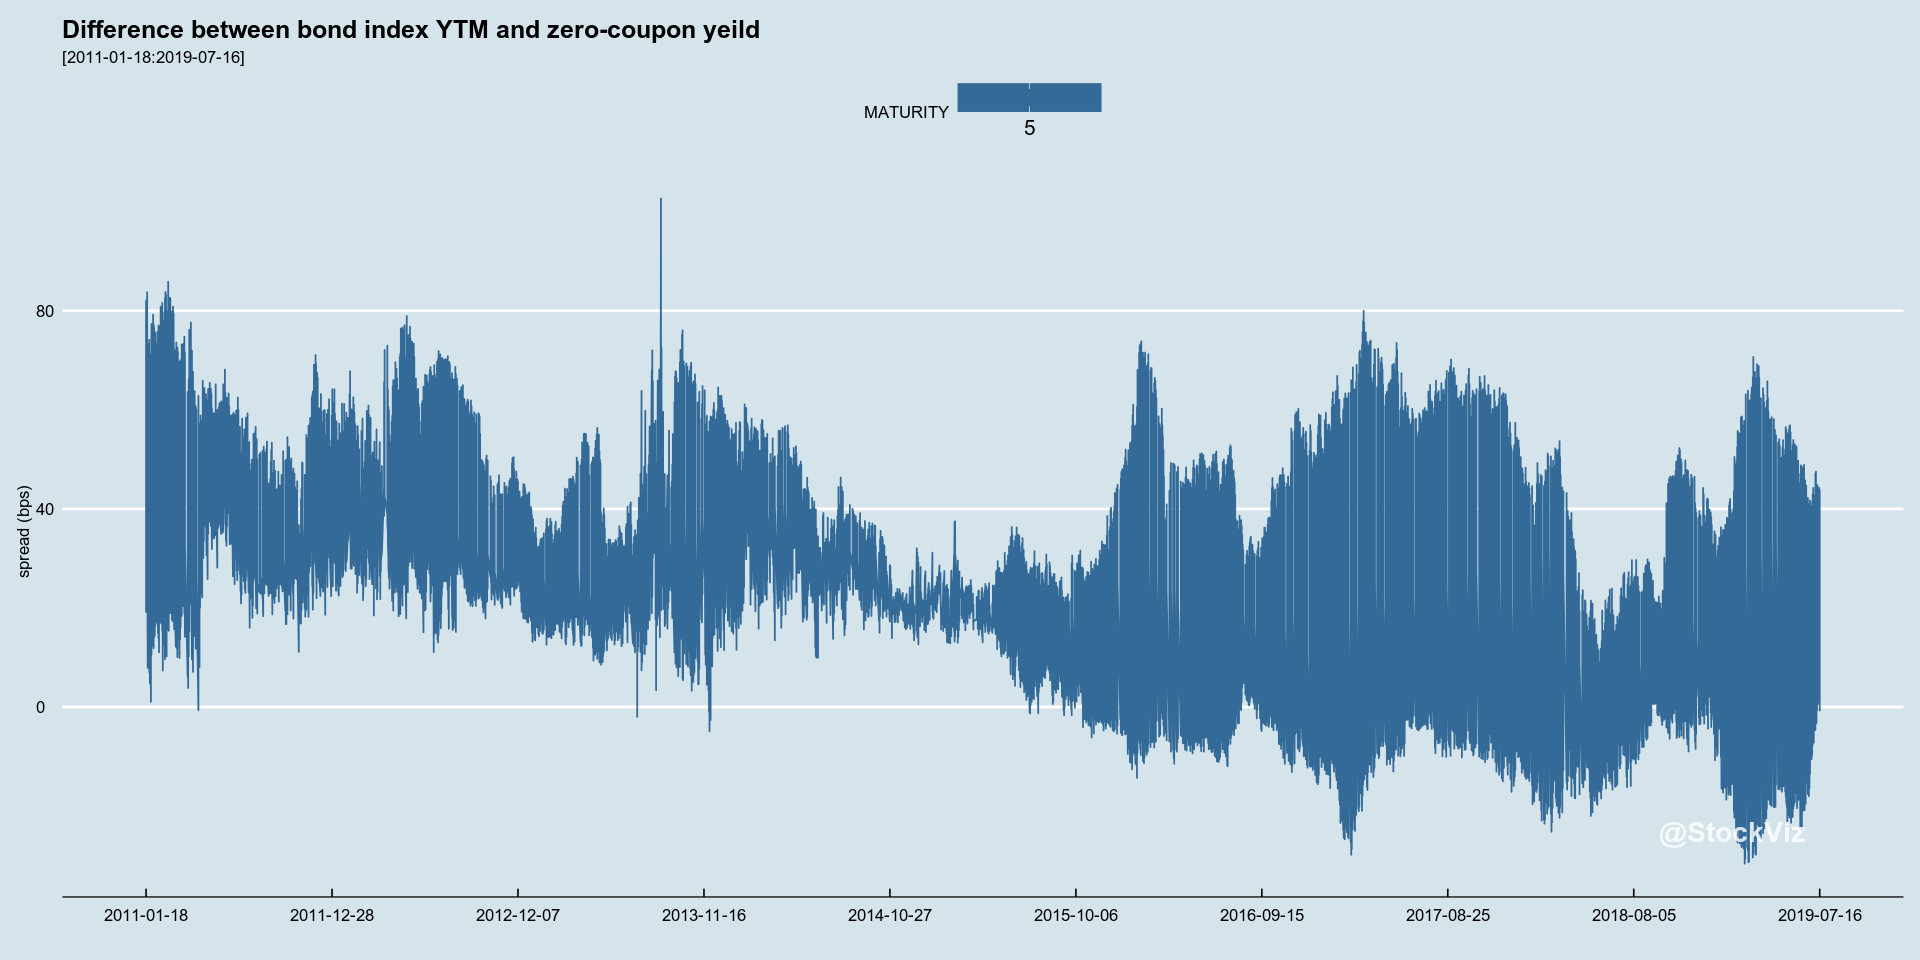

In [4]:
# plot the spread

xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

ggplot(sprdDf, aes(x = TIME_STAMP, y=SPREAD, color=MATURITY)) + 
    theme_economist() +
    geom_line() + 
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='spread (bps)', fill='', 
         title="Difference between bond index YTM and zero-coupon yeild", 
         subtitle=sprintf("[%s:%s]", startDate, endDate)) +
    annotate("text", x=max(sprdDf$TIME_STAMP), y=min(sprdDf$SPREAD), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)  

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)